In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve, curve_fit, leastsq
from scipy.signal import savgol_filter
from scipy.stats import linregress

import os
import re

Defino las reacciones a simular (k estimadas):
    
$k_1 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} NO + H_2S \rightarrow H_2SNO$

$k_2 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} H_2SNO + NO \rightarrow HSNO + HNO$

$k_3 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} 2 HSNO \rightarrow HSSH + 2 NO$

$k_4 = 5.6x10^{6} M^{-1} s^{-1} \hspace{1cm} NO + HNO \rightarrow HN_2O_2$

$k_5 = 8x10^{6} M^{-1} s^{-1} \hspace{1cm} 2 HNO \rightarrow N_2O$

In [3]:
reactions = [
    # (coeff, r_stoich, net_stoich)
    ('k1', {'[NO]': 1, '[H2S]': 1}, {'[NO]': -1, '[H2S]': -1, '[H2SNO]': 1}),
    ('k2', {'[NO]': 1, '[H2SNO]': 1}, {'[NO]': -1, '[H2SNO]': -1, '[HSNO]': 1, '[HNO]': 1}),
    ('k3', {'[HSNO]': 2}, {'[HSNO]': -2, '[HSSH]': 1, '[NO]': 2}),
    ('k4', {'[NO]': 1, '[HNO]': 1}, {'[NO]': -1, '[HNO]': -1, '[HN2O2]': 1}),
    ('k5', {'[HNO]': 2}, {'[HNO]': -2, '[N2O]': 1})
]
names = '[NO] [H2S] [HSNO] [HNO] [HSSH] [H2SNO] [HN2O2] [N2O]'.split()

In [171]:
from operator import mul
from functools import reduce
import sympy as sym

def prod(seq):
    return reduce(mul, seq) if seq else 1

def mk_exprs_symbs(rxns, names):
    # create symbols for reactants
    symbs = sym.symbols(names, real=True, nonnegative=True)
    # map between reactant symbols and keys in r_stoich, net_stoich
    c = dict(zip(names, symbs))
    f = {n: 0 for n in names}
    k = []
    for coeff, r_stoich, net_stoich in rxns:
        k.append(sym.S(coeff))
        r = k[-1]*prod([c[rk]**p for rk, p in r_stoich.items()])
        for net_key, net_mult in net_stoich.items():
            f[net_key] += net_mult*r
    return [f[n] for n in names], symbs, tuple(k)

In [172]:
def replace_fix_and_free(func, fixed_list):
    to_replace = [(ki, fixed_list[ki]) for ki in fixed_list.keys()]
    for i in range(len(func)):
        func[i] = func[i].subs(to_replace)
    return func

#Construyo el sistema de ecuaciones
ydot, y, k = mk_exprs_symbs(reactions, names)

#Reemplazo las constantes que considero fijas:
#fixed_list = {'k1': 3, 'k2':0, 'k3':0, 'k4': 5.6, 'k5': 8} # En uM-1 s-1
fixed_list = {} # En uM-1 s-1
ydot = replace_fix_and_free(ydot, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_free = tuple([ki for ki in k if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')
f = sym.lambdify((y, t) + k_free, ydot, 'numpy')

#Calculo el jacobiano
J = sym.Matrix(ydot).jacobian(y)
J_cb = sym.lambdify((y, t) + k_free, J, 'numpy') 

#Construyo la función
def hno_t(tspan, kvals, y0):
    k_vals = tuple([i for i in kvals])
#    yout = odeint(f, y0, tspan, k_vals, Dfun=J_cb)
    yout = odeint(f, y0, tspan, k_vals, atol=1e-16, rtol=1e-16)
    return yout

In [173]:
y

[[NO], [H2S], [HSNO], [HNO], [HSSH], [H2SNO], [HN2O2], [N2O]]

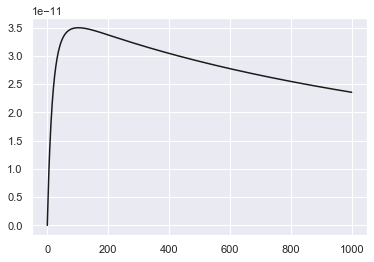

In [174]:
tspan = np.linspace(0, 1000, 1001)
y0 = [2e-6, 10e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

kvals = (6.3e3, #k1
         100,  #k2
         100,    #k3
         5.6e6,  #k4
         8e6)  #k5

sim = hno_t(tspan, kvals, y0)
no = sim[:,0]
h2s = sim[:,1]
hno = sim[:,3]
#plt.plot(tspan, no, 'b')
#plt.plot(tspan, h2s, 'y')
plt.plot(tspan, hno, 'k')
plt.show()

### Carga de experimentos

In [159]:
WD = '/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas H2S-NO/'
experiments = {}
for f in os.listdir(WD):
    name = re.split('_|.txt', f)[0:4]
    name[1] = re.split('uM', name[1])[0]
    name[3] = re.split('uM', name[3])
    name[1] = float(name[1])
    if name[3][1] == '':
        del name[3][1]
        name.append('A')
    elif name[3][1] == 'b':
        del name[3][1]
        name.append('B')
    name[3] = name[3][0].replace('(','.')
    name[3] = float(name[3].replace(')',''))

    if name[0] == 'NO':
        exp = (name[1], name[3], name[4])
    else:
        exp = (name[3], name[1], name[4])
        
    df = pd.read_csv( WD + f, header = None, sep = '\t')
    df.columns = ['time','HNO']
    
    df.time = pd.to_timedelta(df.time, unit = 'minutes')
    df = df.set_index('time')
    df.HNO = df.HNO*1e-6
    
    experiments[exp] = df

### Nuevo enfoque

Dado un experimento, voy a calcular el error cuadratico medio respecto a simulaciones para una serie de valores de las constantes, para poder estimar los mejores parámetros

In [163]:
exps = list(experiments.keys())
print(exps)

[(0.6, 2.0, 'A'), (2.0, 1.0, 'B'), (0.4, 2.0, 'A'), (2.0, 0.2, 'B'), (0.2, 2.0, 'A'), (2.0, 1.5, 'A'), (2.0, 1.5, 'B'), (1.0, 2.0, 'B'), (1.0, 2.0, 'A'), (2.0, 2.0, 'A'), (2.0, 0.6, 'B'), (0.6, 2.0, 'B'), (1.5, 2.0, 'A'), (1.5, 2.0, 'B'), (2.0, 0.2, 'A'), (0.4, 2.0, 'B'), (2.0, 0.6, 'A'), (2.0, 1.0, 'A'), (2.0, 0.4, 'A'), (2.0, 0.4, 'B')]


In [108]:
from scipy.signal import find_peaks

Elijo 1 experimento:

In [264]:
exp = exps[-1]

In [309]:
y0 = [exp[0]*1e-6, exp[1]*1e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tspan = experiments[exp].index.total_seconds().values
hno_exp = experiments[exp].HNO.values
#tspan = tspan[:400]
#hno_exp = hno_exp[:400]


k1_val = []
k2_val = []
k3_val = []
hno_max_val = []
hno_max_t12_val = []
total_error = []

for k1 in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e4, 1e5, 1e6, 1e7, 1e8]:
    for k2 in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e4, 1e5, 1e6, 1e7, 1e8]:
    #for k2 in [100]:
        for k3 in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e4, 1e5, 1e6, 1e7, 1e8]:
        #for k3 in [100]:

            kvals = (k1,     #k1
                     k2,     #k2
                     k3,     #k3
                     5.6e6,  #k4
                     8e6)    #k5

            sim = hno_t(tspan, kvals, y0)
            #plt.plot(tspan, sim[:,3],'k')
            res, _ = find_peaks(sim[:,3], height= 0)
            
            k1_val.append(k1)
            k2_val.append(k2)
            k3_val.append(k3)
            try:
                hno_max_val.append(sim[res[0],3])
                hno_max_t12_val.append(tspan[[res[0]]])
            except:
                hno_max_val.append(np.max(sim[:,3]))
                hno_max_t12_val.append(tspan[np.argmax(sim[:,3])])
            
            #s = (sim[:,3] - np.min(sim[:3]))/np.max(sim[:3])
            #h = (hno_exp - np.min(hno_exp))/np.max(hno_exp)
            #er = np.corrcoef(sim[:,3], hno_exp)[1,0]
            er =  (hno_max_val[-1] - np.max(hno_exp))**2
            total_error.append(er)
                    

In [310]:
error_df = pd.DataFrame(np.array([k1_val, k2_val, k3_val, total_error]).T)
error_df.columns = ['k1','k2','k3', 'total_error']
error_df

,k1,k2,k3,total_error
0,1.000000e-05,1.000000e-05,1.000000e-05,6.523389e-15
1,1.000000e-05,1.000000e-05,1.000000e-04,6.523389e-15
2,1.000000e-05,1.000000e-05,1.000000e-03,6.523389e-15
3,1.000000e-05,1.000000e-05,1.000000e-02,6.523389e-15
4,1.000000e-05,1.000000e-05,1.000000e-01,6.523389e-15
...,...,...,...,...
2192,1.000000e+08,1.000000e+08,1.000000e+04,7.271597e-15
2193,1.000000e+08,1.000000e+08,1.000000e+05,7.257799e-15
2194,1.000000e+08,1.000000e+08,1.000000e+06,7.126619e-15
2195,1.000000e+08,1.000000e+08,1.000000e+07,6.252426e-15


In [311]:
vals = error_df.sort_values(by = 'total_error').head(1).values
vals[0][0:3]

array([1.e+06, 1.e+08, 1.e+08])

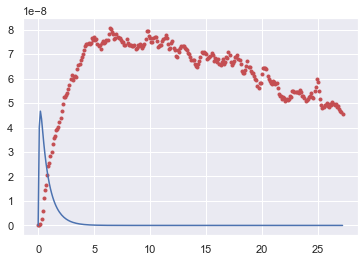

In [312]:
kvals = (vals[0][0], vals[0][1], vals[0][2], 5.6e6, 8e6)
sim = hno_t(tspan, kvals, y0)
plt.plot(tspan, hno_exp, 'r.')
plt.plot(tspan, sim[:,3])

In [287]:
np.corrcoef(sim[:,3], hno_exp)[1,0]

-0.3903886689979153